### Importando as bibliotecas necessárias

In [26]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cloudpickle

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    precision_recall_curve
)

from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
from category_encoders import TargetEncoder 

### Funções de pré-processamento dos dados

In [27]:
# Função para substituir negativos por zero
def negativos_para_zero(X):
    X = X.copy()
    X[X < 0] = 0
    return X

# Função para substituir outliers usando intervalo interquartil (IQR)
def cap_outliers(X):
    X = pd.DataFrame(X).copy()
    for col in X.columns:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_superior = Q3 + 1.5 * IQR
        if limite_superior > 0:
            X[col] = np.where(X[col] > limite_superior, limite_superior, X[col])
    return X

# Função para aplicar (log(x+1)) em variáveis monetárias
def aplica_log1p(X):
    X = pd.DataFrame(X).copy()
    for col in X.columns:
        X[col] = X[col].clip(lower=0)  # evita valores negativos
        X[col] = np.log1p(X[col])
    return X

# Carregando o arquivo csv e criando o DataFrame pandas
df = pd.read_csv('_data/dataset_2021-5-26-10-14.csv', sep= '\t', encoding='utf-8')

# Corrige negativos em "valor_total_pedido"
if "valor_total_pedido" in df.columns:
    df["valor_total_pedido"] = pd.to_numeric(df["valor_total_pedido"], errors="coerce").fillna(0)
    df.loc[df["valor_total_pedido"] < 0, "valor_total_pedido"] = 0


### Utiliza apenas as variáveis escolhidas para o modelo, sendo elas:

- "default_3months", "ioi_36months", "valor_vencido", "valor_total_pedido", "ioi_3months", "valor_por_vencer", "year": possuem área sob a curva ROC maior que AUC ROC > 0.5, então mesmo as que estão proximas de 0.5 não tendo tanto poder discriminatório são mais prováveis de terem relação com outras variáveis que beneficie o modelo;
- "valor_quitado", "dividas_vencidas_qtd": apresentam boa relação entre as variáveis no diagrama de dispersão;
- "month":  histograma apresenta maiores quantidades de default entre janeiro e março;
- "tipo_sociedade", "atividade_principal", "opcao_tributaria": dentre as quatro variáveis categóricas são as que possuem menos valores ausentes.

In [28]:
# Definindo a variável alvo
alvo = "default"

# Colunas numéricas
num_cols = ["default_3months", "ioi_36months", "ioi_3months",
            "valor_por_vencer", "valor_vencido", "valor_quitado", 
            "dividas_vencidas_qtd", "valor_total_pedido", "month", "year"]

# Colunas categóricas
categoricas = [c for c in ["tipo_sociedade", "opcao_tributaria", "atividade_principal"] if c in df.columns]

# Baixa cardinalidade → OneHot
baixa_card = [c for c in categoricas if df[c].nunique(dropna=True) <= 20]
# Alta cardinalidade → TargetEncoder
alta_card = [c for c in categoricas if df[c].nunique(dropna=True) > 20]

### Na seção abaixo ocorrem o pre-processamento dos dados utilizando as funções definidas anteriormente para as variaveis numericas e transforma categorias em colunas binárias (variaveis dummy) para as com menos de 20 valores únicos e codifica cada categoria pelo valor médio da variável alvo (y) dentro daquela categoria para as demais.

In [29]:
# Pré-processamento

# Aplica log depois do cap de outliers Variáveis monetárias
monetarias = [c for c in ["valor_por_vencer", "valor_vencido", "valor_quitado", "valor_total_pedido"] if c in num_cols]

outras_num = [c for c in num_cols if c not in monetarias]

# Numéricas monetárias
pipeline_monetarias = Pipeline([
    ("cap", FunctionTransformer(cap_outliers)),
    ("log", FunctionTransformer(aplica_log1p)),
    ("scaler", StandardScaler())
])

# Demais numéricas
pipeline_num = Pipeline([
    ("cap", FunctionTransformer(cap_outliers)),
    ("scaler", StandardScaler())
])

# Categóricas baixa cardinalidade
pipeline_cat_baixa_card = Pipeline([ ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) ])

# Categóricas alta cardinalidade
pipeline_cat_alta_card = Pipeline([("alvo_enc", TargetEncoder())])

# Monta ColumnTransformer
transformers = []
if monetarias:
    transformers.append(("monetarias", pipeline_monetarias, monetarias))
if outras_num:
    transformers.append(("outras_num", pipeline_num, outras_num))
if baixa_card:
    transformers.append(("cat_baixa_card", pipeline_cat_baixa_card, baixa_card))
if alta_card:
    transformers.append(("cat_alta_card", pipeline_cat_alta_card, alta_card))

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

# Define as features e o alvo
X = df[num_cols + baixa_card + alta_card]
y = df[alvo].astype(int)

# Divisão entre treino e teste, respectivamente 80% e 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Amostra de treino:", X_train.shape, "Amostra de teste:", X_test.shape)

Amostra de treino: (93818, 13) Amostra de teste: (23455, 13)


### O XGBoost foi escolhido por ser um algoritmo capaz de lidar bem com grandes volumes de dados, variáveis heterogêneas (numéricas e categóricas) e classes desbalanceadas. Além disso, oferece suporte a GPU, acelerando o treinamento.

ROC AUC: 0.9282040120926667
Melhor threshold para F1 classe 1: 0.338
Precisão: 0.79 | Recall: 0.70 | F1: 0.74


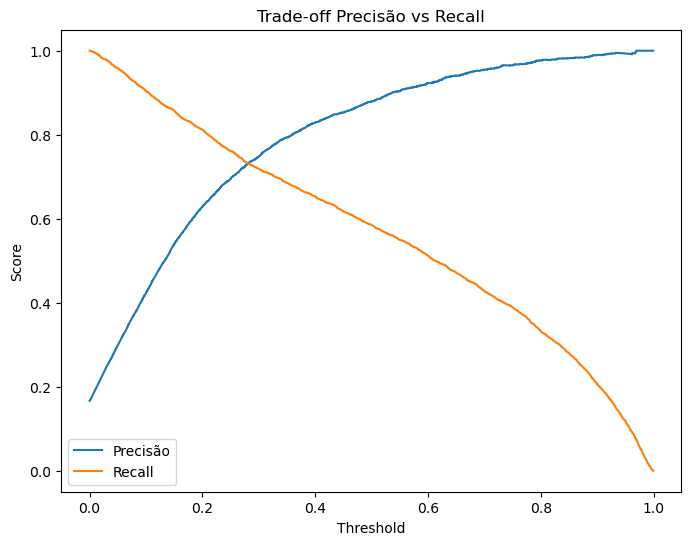

=== XGBoost + SMOTE + threshold ajustado ===
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     19546
           1       0.79      0.70      0.74      3909

    accuracy                           0.92     23455
   macro avg       0.86      0.83      0.85     23455
weighted avg       0.91      0.92      0.92     23455



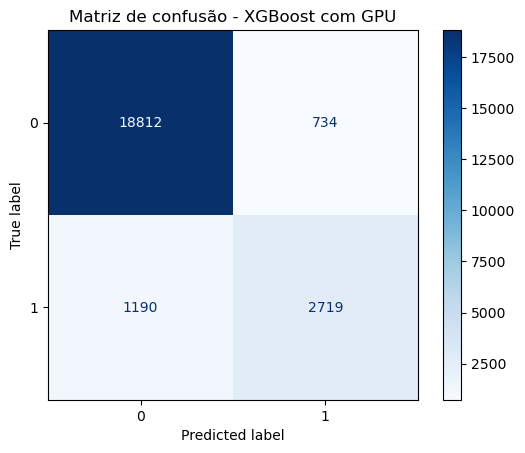

In [30]:
# Modelo com XGBoost
pipeline_xgb = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", xgb.XGBClassifier(
        device="cuda",
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])

pipeline_xgb.fit(X_train, y_train)

# Avaliação inicial
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_proba_xgb)
print("ROC AUC:", roc_auc)

# Threshold tuning, maximizando F1 da classe 1, pois como a distribuição da variável alvo é desbalanceada é necessário utilizar alguma técnica para melhorar
# o desempenho do modelo em classificar os casos na classe minoritária.
prec, rec, thr = precision_recall_curve(y_test, y_proba_xgb)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1_scores)
best_thr = thr[best_idx]

# Apresenta o resultado do valor otimo encontrado para o threshold
print(f"Melhor threshold para F1 classe 1: {best_thr:.3f}")
print(f"Precisão: {prec[best_idx]:.2f} | Recall: {rec[best_idx]:.2f} | F1: {f1_scores[best_idx]:.2f}")

# Plot trade-off
plt.figure(figsize=(8,6))
plt.plot(thr, prec[:-1], label="Precisão")
plt.plot(thr, rec[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Trade-off Precisão vs Recall")
plt.show()

# Avaliação final com threshold ajustado
y_pred_xgb = (y_proba_xgb >= best_thr).astype(int)

print("=== XGBoost + SMOTE + threshold ajustado ===")
print(classification_report(y_test, y_pred_xgb))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap="Blues")
plt.title("Matriz de confusão - XGBoost com GPU")
plt.show()

In [31]:
# Salvar modelo e threshold em artifacts
os.makedirs("artifacts", exist_ok=True)

joblib.dump(best_thr, "artifacts/best_threshold_xgb.pkl")

with open("artifacts/pipeline_xgb.pkl", "wb") as f:
    cloudpickle.dump(pipeline_xgb, f)
